In [ ]:
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear  
# inline in the notebook rather than in a new window.
%matplotlib inline

# set default size of plots
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# import the necessary packages
import cv2
import os
import glob

# OpenCV Contours

In [ ]:
imagePath = './datasets/breaking-captcha/solved-captchas/75947.png'
image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)

In [ ]:
# threshold the image to reveal the digits
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
plt.imshow(thresh)

In [ ]:
contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
(x, y, w, h) = cv2.boundingRect(contours[-1])
print("[INFO] contour location {}, {}, {}, {}".format(x, y, w, h))
roi = gray[y - 5:y + h + 5, x - 5:x + w + 5]
plt.imshow(roi)

# Annotating

using utils/annotate.py to annotating images

# Training the Captcha Breaker

In [ ]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob

from utils.image_preprocessor import AspectAwarePreprocessor
from utils.image_preprocessor import ImagePreprocessor
from utils.image_preprocessor import ImageToArrayPreprocessor

In [ ]:
# path to input dataset
dataset = './output/breaking-captcha'
# path to output model
model_path = './output/model_persistence/breaking-captcha-lenet.hdf5'

In [ ]:
aap = AspectAwarePreprocessor(28, 28)
iap = ImageToArrayPreprocessor()

In [ ]:
# initialize the data and labels
data = []
labels = []

imagePaths = glob.glob('./output/breaking-captcha/**/*.png', recursive=True)

# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = aap.preprocess(image)
    image = iap.preprocess(image)
    data.append(image)
    
    # extract the class label from the image path and update the
    # labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

In [ ]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

# convert the labels from integers to vectors
lb = LabelBinarizer().fit(trainY)
trainY = lb.transform(trainY)
testY = lb.transform(testY)

In [ ]:
from classifiers.lenet5 import LeNet5

# initialize the model
print("[INFO] compiling model...")

model = LeNet5().build(width=28, height=28, depth=1, classes=9)
opt = SGD(lr=0.01)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=32, epochs=15, verbose=1)

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
predictions.argmax(axis=1), target_names=lb.classes_))

# save the model to disk
print("[INFO] serializing network...")
model.save(model_path)

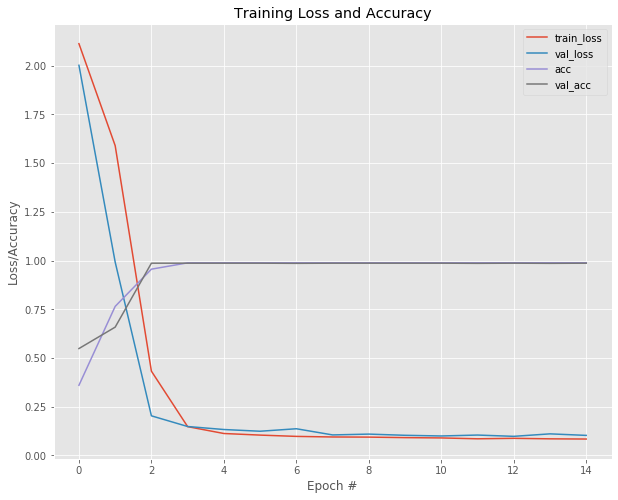

In [11]:
# plot the training + testing loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 15), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 15), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 15), H.history["acc"], label="acc")
plt.plot(np.arange(0, 15), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# Testing the Captcha Breaker

In [ ]:
# import the necessary packages
from keras.models import load_model
import numpy as np
import cv2

In [ ]:
# path to input directory of images
input = './dataset/breaking-captcha/unsolved-captchas'
# path to input model
model_path = './output/model_persistence/breaking-captcha-lenet.hdf5'

In [ ]:
# load the pre-trained network
print("[INFO] loading pre-trained network...")
model = load_model(model_path)

In [ ]:
# randomly sample a few of the input images
imagePaths = glob.glob('./datasets/breaking-captcha/unsolved-captchas/*.png', recursive=True)
imagePaths = np.random.choice(imagePaths, size=(10,), replace=False)

In [10]:
# loop over the image paths
for imagePath in imagePaths:
    print("[INFO] processing image {}".format(imagePath))
    # load the image and convert it to grayscale, then pad the image
    # to ensure digits caught only the border of the image are
    # retained
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # threshold the image to reveal the digits
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    # initialize the output image as a "grayscale" image with 3
    # channels along with the output predictions
    output = cv2.merge([gray] * 3)
    predictions = []
    
    # loop over the contours
    for c in contours:
        # compute the bounding box for the contour then extract the digit
        (x, y, w, h) = cv2.boundingRect(c)
        print("[INFO] contour location {}, {}, {}, {}".format(x, y, w, h))
        roi = gray[y - 5:y + h + 5, x - 5:x + w + 5]
        # pre-process the ROI and classify it then classify it
        roi = aap.preprocess(roi)
        roi = iap.preprocess(roi)
        roi = np.expand_dims(roi, axis=0) / 255.0
        pred = model.predict(roi).argmax(axis=1)[0] + 1
        predictions.append(str(pred))
        
        # draw the prediction on the output image
        cv2.rectangle(output, (x - 2, y - 2), (x + w + 4, y + h + 4), (0, 255, 0), 1)
        cv2.putText(output, str(pred), (x - 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 255, 0), 2)
        
    # show the output image
    print("[INFO] captcha: {}".format("".join(predictions)))
    cv2.imshow("Output", output)
    cv2.waitKey()
    cv2.destroyAllWindows()

[INFO] processing image ./datasets/breaking-captcha/unsolved-captchas/91.png
[INFO] contour location 103, 20, 7, 10
[INFO] contour location 18, 10, 7, 10
[INFO] contour location 65, 14, 6, 10
[INFO] contour location 88, 11, 6, 10
[INFO] contour location 44, 7, 7, 10
[INFO] captcha: 69217
[INFO] processing image ./datasets/breaking-captcha/unsolved-captchas/188.png
[INFO] contour location 70, 22, 7, 10
[INFO] contour location 110, 8, 7, 10
[INFO] contour location 47, 18, 7, 10
[INFO] contour location 86, 19, 6, 10
[INFO] contour location 27, 12, 7, 10
[INFO] captcha: 88913
[INFO] processing image ./datasets/breaking-captcha/unsolved-captchas/1462.png
[INFO] contour location 39, 8, 7, 10
[INFO] contour location 62, 7, 7, 10
[INFO] contour location 79, 20, 7, 10
[INFO] contour location 97, 16, 7, 10
[INFO] contour location 25, 12, 7, 10
[INFO] captcha: 88995
[INFO] processing image ./datasets/breaking-captcha/unsolved-captchas/1474.png
[INFO] contour location 19, 19, 7, 10
[INFO] contour 

Well Done